# Symptom Burden & Clustering.

In order to consider both the occurance and severity we calculate a symptom burden per day for each symptom.

$$ SB(S_i) = \frac{\sum Severity}{W_l} $$

Where

$$ SB : Symptom Burden \ S_i \vee [hotflashes, fatigue, ...] \ W_l : Length of the window \$$

In [ ]:
import pandas as pd
import numpy as np
from sensorfabric.athena import athena
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
%set_env AWS_PROFILE=opensci

env: AWS_PROFILE=opensci


In [ ]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

In [ ]:
# The window size of the data we are looking at to calculate the symptom burden.
# For this experiment we are looking at the first 7 days.
window_size = 7

In [ ]:
query = """
with f as (
  select s.*, day(s.datetime - ss.first_symptom_date) days_offset
    from symptompp s
    inner join first_symptom_date ss
    on s.uid = ss.uid
)
select uid, name, sum(severity) sum_severity, 
  count(distinct(days_offset)) days_recorded,
  sum(severity) / count(distinct(days_offset)) "avg_burden_per_day"
  from f
  where days_offset < {window} and allday = false and severity > 0
  group by uid, name
  order by uid, name
""".format(window = window_size)

In [ ]:
results = db.execQuery(query, cached=True)

In [ ]:
results

,uid,name,sum_severity,days_recorded,avg_burden_per_day
0,5f8e89640054a6c5fab1544d,bloating,3,1,3
1,5f8e89640054a6c5fab1544d,breast_swelling,6,1,6
2,5f8e89640054a6c5fab1544d,constipation,2,1,2
3,5f8e89640054a6c5fab1544d,dry_skin,10,1,10
4,5f8e89640054a6c5fab1544d,headaches,10,1,10
...,...,...,...,...,...
666,64220cd5df7eeb0028d605ba,nausea,2,1,2
667,64220cd5df7eeb0028d605ba,night_sweats,4,1,4
668,642216addf7eeb0028d605eb,brain_fog,2,1,2
669,642216addf7eeb0028d605eb,insomnia,3,1,3


This code has been moved to `util.py` as a libray method. 

Convert the symptom burden dataset into a clustering ready dataset.

In [ ]:
def clusterMatrix(data):
    frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
    uidmap = {}
    # Start breaking the users frame and extract data from it to add to the data matrix.
    temp = None  # Temp dictionary that holds the symptom counts for each user.
    for uid, sname, burden in zip(data['uid'].values, data['name'].values, data['avg_burden_per_day'].values):
        if not (uid in uidmap):
            # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
            if not (temp is None):
                temp = pd.Series(temp)
                temp = temp.to_frame().T
                frame = pd.concat([frame, temp], ignore_index=True)
            temp = {}  # Start fresh again.
            temp['uid'] = uid
            uidmap[uid] = 1
        temp[sname] = float(burden)
    frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
    frame = frame.fillna(0)
    
    return frame

In [ ]:
cluster_ready = clusterMatrix(results)

In [ ]:
cluster_ready

,bloating,breast_swelling,constipation,dry_skin,headaches,nausea,vomiting,allergies,joint_pain,hot_flashes,...,dry_eyes,ringing_ears,breast_pain,nipple_discharge,ovulation_pain,chills,muscle_tension,memory_lapse,depression,vertigo
uid,,,,,,,,,,,,,,,,,,,,,
5f8e89640054a6c5fab1544d,3.0,6.0,2.0,10.0,10.0,4.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5f8f175466dae0d0328adb76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5f8f260566dae0d0328adb7e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5f8f274466dae0d0328adb80,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5f914dfaa42cd9d7053ec1d8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6421a42cdf7eeb0028d60507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6421b389df7eeb0028d6053f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
6421bfdadf7eeb0028d6055b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This method has been moved to `util.py` after testing.

hot_flashes: 9.72%
night_sweats: 6.20%
joint_pain: 6.06%
insomnia: 5.91%
fatigue: 5.59%
dry_skin: 4.92%
bloating: 4.55%
anxiety: 4.39%
headaches: 4.11%
itchy_skin: 3.69%
sex_drive: 3.25%
mood_swings: 2.85%
cramps: 2.61%
depression: 2.54%
allergies: 2.52%
brain_fog: 2.48%
memory_lapse: 2.18%
muscle_tension: 2.12%
dry_eyes: 1.84%
constipation: 1.82%
dizzy: 1.73%
tingling_extremeties: 1.66%
breast_pain: 1.54%
heartburn: 1.46%
vaginal_dryness: 1.41%
chills: 1.37%
nausea: 1.28%
diarrhea: 1.26%
ringing_ears: 1.24%
irregular_beat: 1.21%
painful_intercourse: 1.17%
incontinence: 1.16%
spotting: 0.99%
ovulation_pain: 0.72%
vertigo: 0.70%
breast_swelling: 0.68%
uti: 0.45%
yeast_infection: 0.36%
vomiting: 0.16%
nipple_discharge: 0.10%


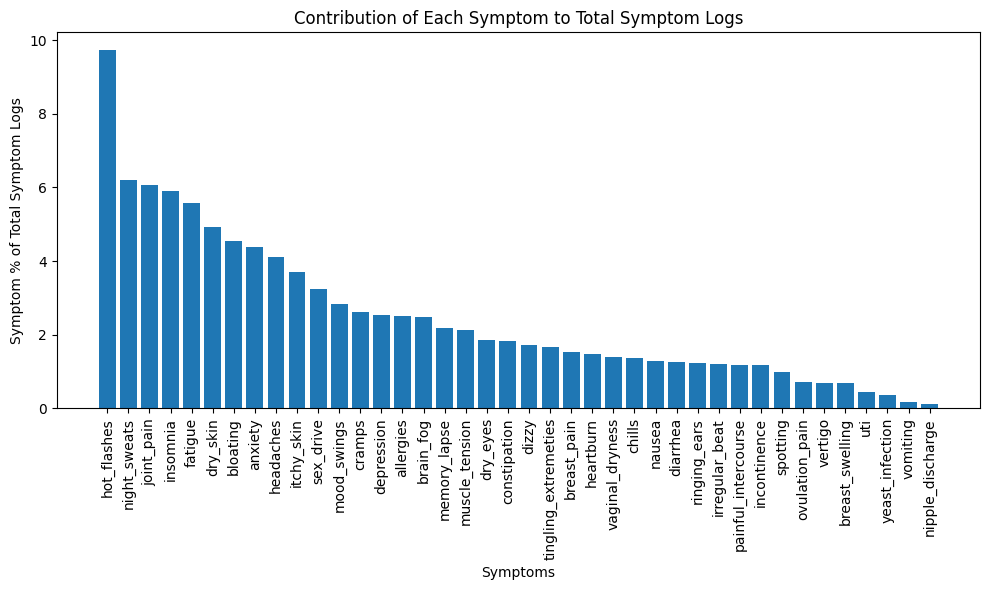

In [ ]:
# Symptom Frequency by % of total symptoms, for each symptom

# Step 1: Calculate the total count of each symptom type (sum across columns)
symptom_totals = frame.sum(axis=0)

# Step 2: Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Step 3: Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Step 4: Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Step 5: Print out each symptom type and its corresponding percentage in the sorted order
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
   print(f"{symptom}: {count:.2f}%")

symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values)
plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.title("Contribution of Each Symptom to Total Symptom Logs")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

In [ ]:
frame = cluster_ready

In [ ]:
symptoms = frame.columns.values
sframe = frame[symptoms]
sframe = (sframe - sframe.mean()) / sframe.std()
cmatrix = sframe.cov()

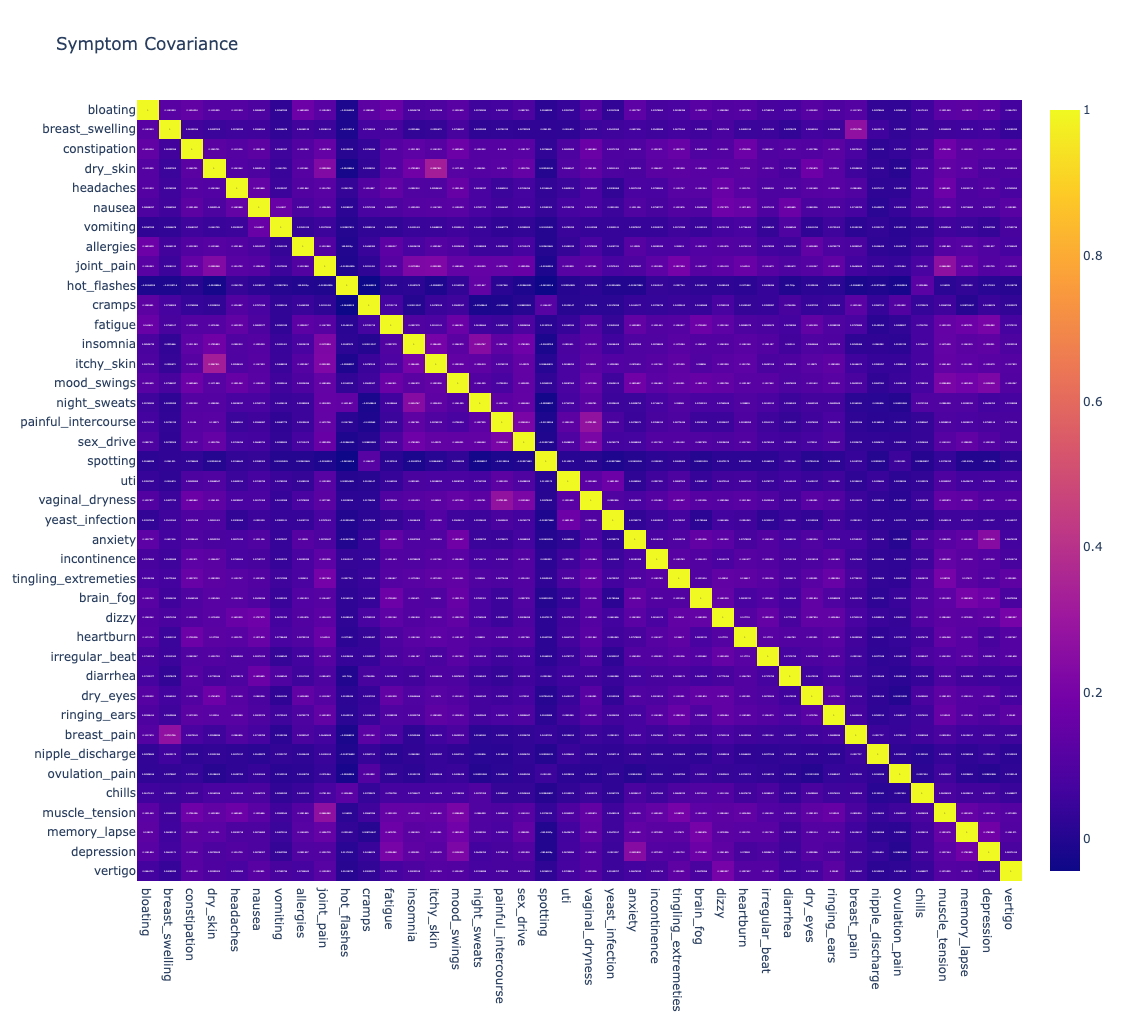

In [ ]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()

## Find pairs of symptoms with more than 20% corelation.

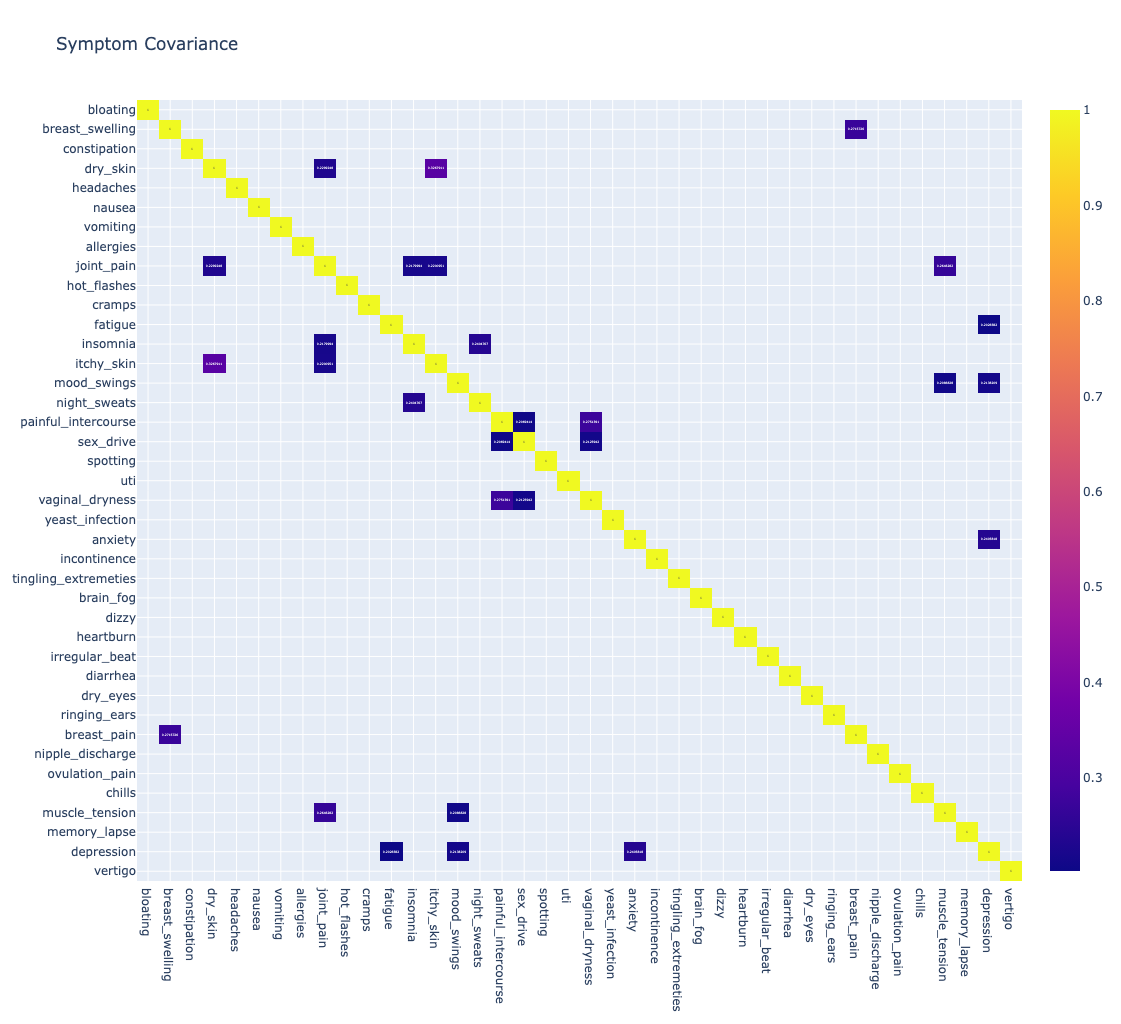

breast_swelling - breast_pain - 0.2715725894344928
dry_skin - joint_pain - 0.2299248060867094
dry_skin - itchy_skin - 0.3267910869801254
joint_pain - dry_skin - 0.2299248060867094
joint_pain - insomnia - 0.21799942166164074
joint_pain - itchy_skin - 0.22009508871809205
joint_pain - muscle_tension - 0.2646282233569329
fatigue - depression - 0.20265819744559052
insomnia - joint_pain - 0.21799942166164074
insomnia - night_sweats - 0.24047674706738933
itchy_skin - dry_skin - 0.3267910869801254
itchy_skin - joint_pain - 0.22009508871809205
mood_swings - muscle_tension - 0.2086828402567432
mood_swings - depression - 0.21382087561043764
night_sweats - insomnia - 0.24047674706738933
painful_intercourse - sex_drive - 0.20694136128340526
painful_intercourse - vaginal_dryness - 0.2751390988861897
sex_drive - painful_intercourse - 0.20694136128340526
sex_drive - vaginal_dryness - 0.21259417126230096
vaginal_dryness - painful_intercourse - 0.2751390988861897
vaginal_dryness - sex_drive - 0.21259417

In [ ]:
th = 0.2
fmatrix = cmatrix[cmatrix >= th]
fig = px.imshow(fmatrix, 
                width=1024, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
indexes = fmatrix.index.values
for s in symptoms:
    paired = fmatrix[s].dropna().index.values
    # We can go ahead print it out. 
    for p in paired:
        if not (s == p):
            print('{} - {} - {}'.format(s, p, fmatrix.loc[s][p]))

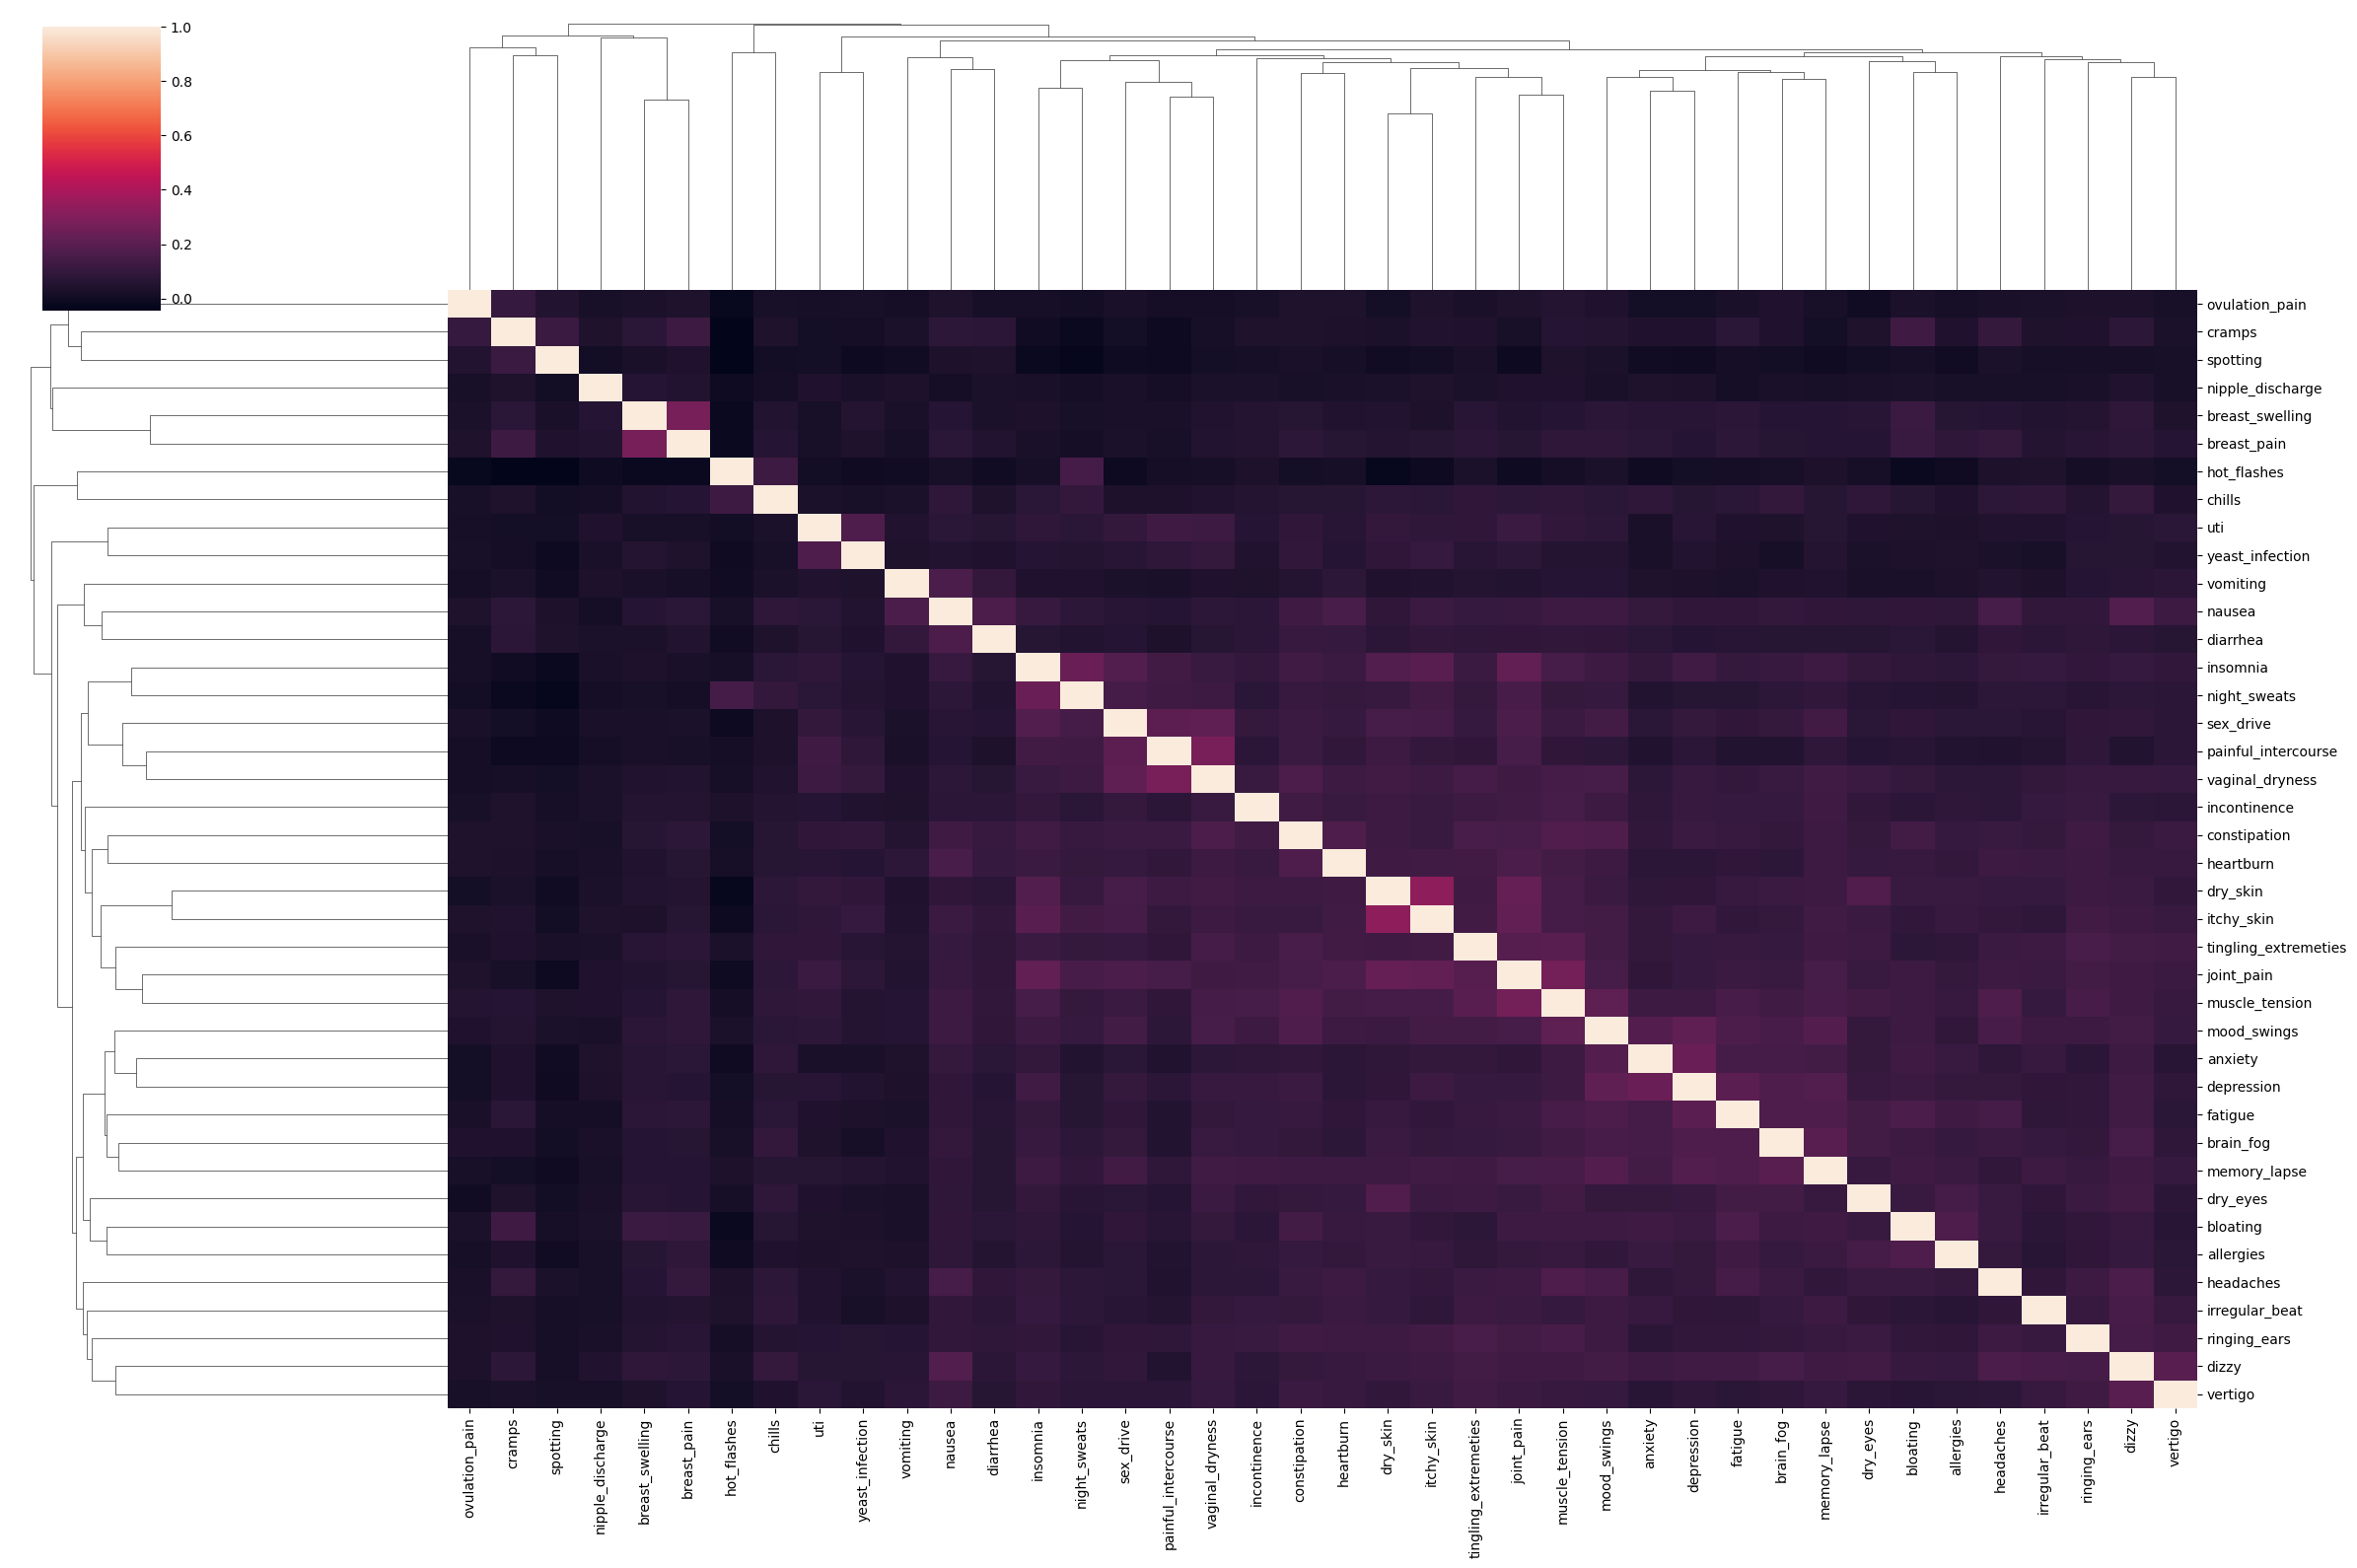

In [ ]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

## Perform PCA analysis on the data.

PCA1 - 0.23, 0.23
PCA2 - 0.12, 0.34
PCA3 - 0.06, 0.40
PCA4 - 0.04, 0.45
PCA5 - 0.04, 0.48
PCA6 - 0.04, 0.52
PCA7 - 0.03, 0.55
PCA8 - 0.03, 0.59
PCA9 - 0.03, 0.62
PCA10 - 0.03, 0.65
PCA11 - 0.02, 0.67
PCA12 - 0.02, 0.69
PCA13 - 0.02, 0.71
PCA14 - 0.02, 0.73
PCA15 - 0.02, 0.75


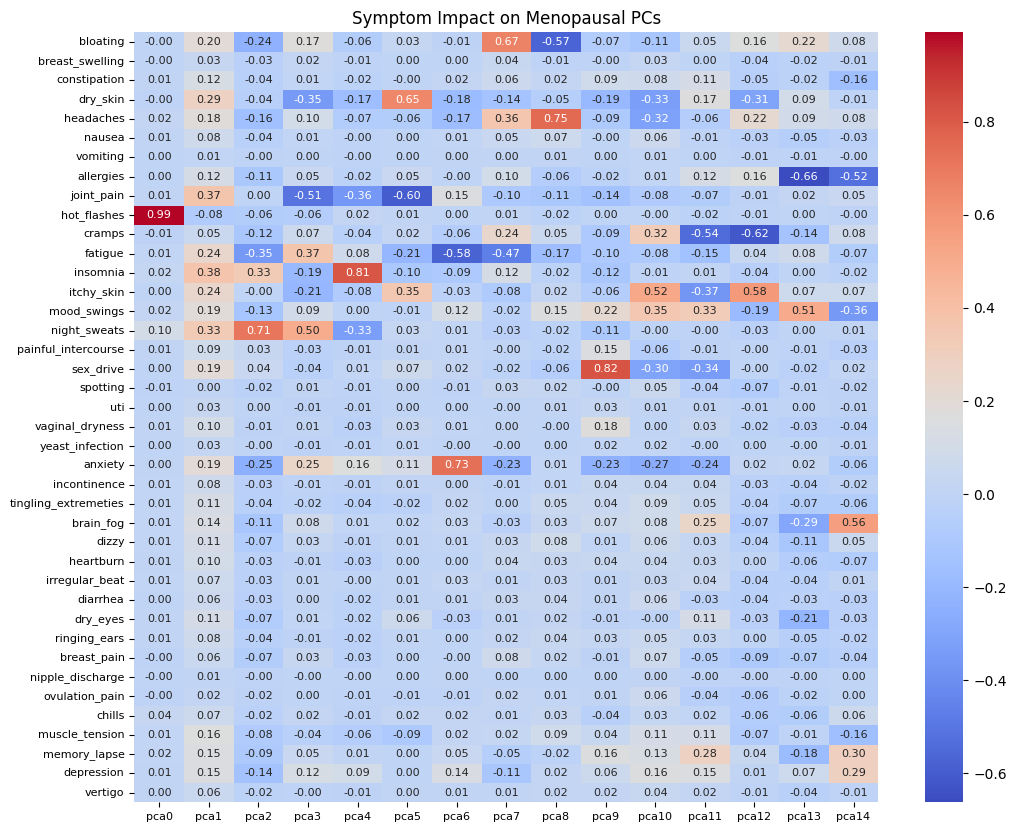

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15, svd_solver='full')
X = frame[symptoms]

pca.fit(X)
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

pcacomponents = pca.fit_transform(X)
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

# Create a heatmap using seaborn and matplotlib
plt.figure(figsize=(12, 10))
sns.heatmap(impact, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of x-axis and y-axis tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set the title and adjust its font size
plt.title('Symptom Impact on Menopausal PCs', fontsize=12)

plt.show()

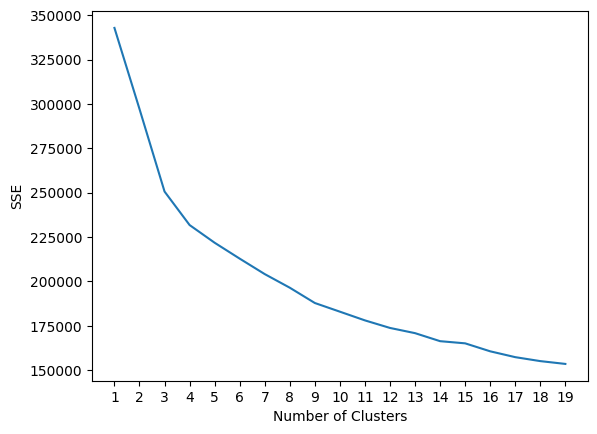

Knee - 4


In [ ]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)
    
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

print('Knee - {}'.format(kl.knee))

In [ ]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 4202
1 - 13887
2 - 266
3 - 3626


## Get the users which belong to each of these clusters

In [ ]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

In [ ]:
## The query can only be so long, so we chunk the uid filter up into sections of 100.
def getTopSymptoms(users, top=5):
    if len(users) == 0:
        return pd.DataFrame(columns=['name', 'occ'])  # Return an empty DataFrame if no users in the segment
    
    results = pd.DataFrame()
    
    for sindex in range(0, len(users), 100):

        where_query = "uid IN ('{}')".format("','".join(users[sindex:min(sindex+100, len(users))]))

        query = """
            SELECT name, COUNT(name) AS occ FROM symptoms 
            WHERE {where}
            GROUP BY name
            ORDER BY occ DESC
            LIMIT {top}
        """.format(where=where_query, top=top)
    
        _results = db.execQuery(query, cached=True)
        results = pd.concat([results, _results])
        
    return results

In [ ]:
getTopSymptoms(user_segments[1], top=5)

,name,occ
0,fatigue,123
1,bloating,113
2,headaches,85
3,constipation,80
4,anxiety,72
...,...,...
0,fatigue,58
1,anxiety,46
2,cramps,41
3,joint_pain,37


In [ ]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

KeyboardInterrupt: 